# Deformation-vorticity formulation

We are going to repeat the same process, but with a different library, splitting ∇U into its symmetric and skew parts.

In [1]:
import numpy as np
from matsindy.feature_library import FeatureLibrary

from ipywidgets import interactive, fixed
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.rcParams['figure.figsize'] = [15, 8]

## Load data

We are going to load data which is already in the form of a dictionary using `np.load`. This is a bead-rod model simulation of 100 polymer chains in a turbulent flow.

In [2]:
dataset = np.load('dataset/turbulence_1_PD_Wi1000_nlinks1000_nmol100_lite.npz')

Let's have a look at the content:

In [3]:
list(dataset.keys())

['gradU', 'S_std', 'S_average', 't', 'A_average', 'A_std']

We rename the variables and use the D-W formuation:

In [4]:
data = {'t': dataset['t'],
        'D': 0.5*(dataset['gradU'] + np.transpose(dataset['gradU'], axes=(0, 2, 1))),
        'W': 0.5*(dataset['gradU'] - np.transpose(dataset['gradU'], axes=(0, 2, 1))),
        'S': dataset['S_average']
       }

variable_names = {'S', 'D', 'W'}
transpose_map = {'S':'S', 'D':'D', 'W':'-W'}

## Define features

This process is explained in the first notebook. Here we bake a library of features which are second order in the stress and velocity gradient.

In [5]:
# Matrix features
library = FeatureLibrary.from_polynomial_matrices(variable_names=variable_names, 
                                                  transpose_map=transpose_map, 
                                                  n_terms=4, intercept=True, symmetry='symmetric')
# Scalar features
library_trace = FeatureLibrary.from_polynomial_traces(variable_names, transpose_map, n_terms=4, intercept=False)
library_trace.remove_by_name('tr(D)')
library_trace = library_trace + library_trace*library_trace

# Combine and trim
library = library + library_trace*library
library.trim({'S':2, 'D':1, 'W':1})

Type of feature output: matrix
Symmetry of features: symmetric
Variables names: {'D', 'S', 'W'}
Variables transpose map: {'S': 'S', 'D': 'D', 'W': '-W'}
Number of feature_functions: 60
(0)	I
(1)	D
(2)	S
(3)	D∘S + (D∘S)ᵀ
(4)	D∘W + (D∘W)ᵀ
(5)	S∘S
(6)	S∘W + (S∘W)ᵀ
(7)	D∘S∘S + (D∘S∘S)ᵀ
(8)	D∘S∘W + (D∘S∘W)ᵀ
(9)	S∘D∘S
(10)	S∘D∘W + (S∘D∘W)ᵀ
(11)	S∘S∘W + (S∘S∘W)ᵀ
(12)	S∘W∘D + (S∘W∘D)ᵀ
(13)	S∘W∘S + (S∘W∘S)ᵀ
(14)	D∘S∘S∘W + (D∘S∘S∘W)ᵀ
(15)	D∘S∘W∘S + (D∘S∘W∘S)ᵀ
(16)	D∘W∘S∘S + (D∘W∘S∘S)ᵀ
(17)	S∘D∘S∘W + (S∘D∘S∘W)ᵀ
(18)	S∘D∘W∘S + (S∘D∘W∘S)ᵀ
(19)	S∘S∘D∘W + (S∘S∘D∘W)ᵀ
(20)	tr(S)I
(21)	tr(S)D
(22)	tr(S)S
(23)	tr(S)(D∘S + (D∘S)ᵀ)
(24)	tr(S)(D∘W + (D∘W)ᵀ)
(25)	tr(S)(S∘W + (S∘W)ᵀ)
(26)	tr(S)(D∘S∘W + (D∘S∘W)ᵀ)
(27)	tr(S)(S∘D∘W + (S∘D∘W)ᵀ)
(28)	tr(S)(S∘W∘D + (S∘W∘D)ᵀ)
(29)	tr(D∘S)I
(30)	tr(D∘S)S
(31)	tr(D∘S)(S∘W + (S∘W)ᵀ)
(32)	tr(D∘W)I
(33)	tr(D∘W)S
(34)	tr(D∘W)S∘S
(35)	tr(S∘S)I
(36)	tr(S∘S)D
(37)	tr(S∘S)(D∘W + (D∘W)ᵀ)
(38)	tr(S∘W)I
(39)	tr(S∘W)D
(40)	tr(S∘W)S
(41)	tr(S∘W)(D∘S + (D∘S)ᵀ)
(42)	tr(D∘S∘S)I
(43)	

## Evaluate features

We evalulate the features from the original (noisy) data and store them in a list. These are features that would be used in a direct (*strong form*) application of SINDy.

In [6]:
features = []
for featurize in library.feature_functions:
    features.append(featurize(data))

In [7]:
def inspect(feature_arg):

    t = data['t']
    f = features[feature_arg]
    for i in range(3):
        for j in range(i, 3):
            plt.plot(t, f[:, i, j], linewidth=2, label=f'{i}{j}')
    plt.legend()
    plt.show()


w = interactive(inspect, feature_arg=widgets.Dropdown(
                    options=list(zip(library.feature_names, range(len(library)))),
                    value=0,
                    description='Feature precursor:',
                    disabled=False,
                    )
               )
w

interactive(children=(Dropdown(description='Feature precursor:', options=(('I', 0), ('D', 1), ('S', 2), ('D∘S …

### Make weak-form features

From the literature, weak-form SINDy is more resilient to noisy data. The weak form is simply achieved by projection (weighted sum in our case) onto test functions. Here, we call the test functions *windows*, refering to signal processing. Sampling the weak-form problem is then, for each window, projecting the stress or conformtation tensor onto `diff(window)` and each feature onto `window`, where `diff` is a finite differenciation function. In this descrete setting, the strong-form problem with Euler scheme is actually a special case where `window = [0, 1, 0]` and `diff(window) = [0, -1, 1]`.

A few important remarks:

1. Using windows with a larger support acts as a low-pass filter on the features. However, as pointed out by (https://arxiv.org/abs/2005.04339), features are evaluated before this filtering occurs, so that no assumption is made on the smoothness of the origninal data.

2. It is not obvious which window shape we should use. Some are better at filtering out high frequencies but is this really what matters? In our case, we don't know much about the properties of the noise. For example, using a rectangular window is not the best choice for noise, but it brings the problem closer to what we ultimately want to do: evaluate the stress (and not the rate of change, which is only a proxy). Applying a rectangular window is like integrating the data over chunks of time, producing an appraoch similar to that of Hayden Schaeffer and Scott G. McCalla, https://doi.org/10.1103/PhysRevE.96.023302, but avoiding drift.

3. We don't go into the complications of optimal window placement, which is a data selection process after all. At this point, we are still agnostic about the information content of the data, and we make the following choice: for a given window size, windows are distributed to cover the entire data but don't overlap (some data points at the end of the simulated scenario may be excluded). Therefore this approach is equivalent to a low-pass filtering followed by downsampling (in signal processing sense): if we choose a window size greater than one, we end up with less data in the weak form. Now, we can do this process with different window sizes and shapes, and regenerate as many weak-form data points as we want.

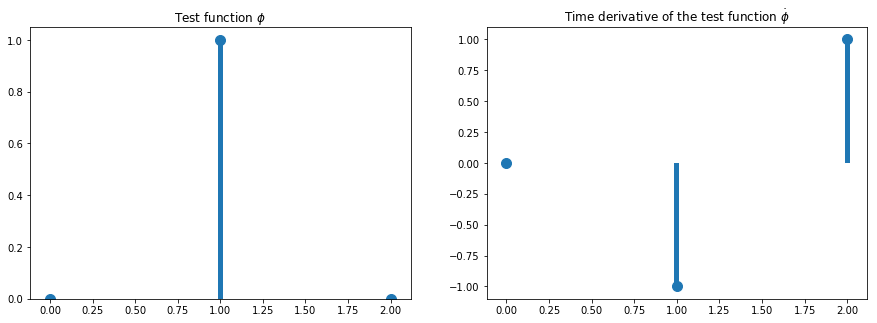

In [8]:
from matsindy.weak import make_window

active_length = 1

window = make_window(active_length, 'rectangular')

width = len(window)
x = np.arange(width)
#print(window)
wind_diff = np.zeros(width)
# derivative: 
wind_diff[1:] = -np.diff(window)
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(ncols=2)
ax[0].bar(x, window, width=0.01*width)
ax[0].plot(window,'o',markersize=10)
ax[0].set_title('Test function $\phi$')
ax[1].bar(x, wind_diff, width=0.01*width)
ax[1].plot(wind_diff,'o',markersize=10)
ax[1].set_title('Time derivative of the test function $\dot\phi$')
plt.show()

In [9]:
from matsindy.weak import weak_diff, weak_form

# Target

dt = data['t'][1]-data['t'][0]  # Assuming uniform time-step
ys = weak_diff(data['S'], dt, window)

# Weak-form features
wfeatures = np.array([weak_form(feature, dt, window) for feature in features])

## Assemble matrix before regression 

Note: at this point, time differentiation has already been done, so the order of data points doesn't matter. We split the data into a training set and a testing set.

In [16]:
train_size = 0.5

train_mask = np.zeros(len(ys), dtype='bool')
train_mask[:int(len(ys)*train_size)] = True
np.random.seed(2023)
np.random.shuffle(train_mask)

print(ys.shape)
print(wfeatures.shape)

ys_train, ys_test = ys[train_mask], ys[~train_mask]
wfeatures_train, wfeatures_test = wfeatures[:,train_mask], wfeatures[:,~train_mask]

(694, 3, 3)
(60, 694, 3, 3)


In [17]:
# Reshape
y_train, y_test = ys_train.flatten(), ys_test.flatten()

X_train = wfeatures_train.reshape((len(wfeatures), len(y_train))).T
X_test = wfeatures_test.reshape((len(wfeatures), len(y_test))).T

In [18]:
print('Number of features: ', len(wfeatures))
print('Rank of X_train:', np.linalg.matrix_rank(X_train))

Number of features:  60
Rank of X_train: 37


## Regression

Any algorithm utilising the value of the coefficient to select the models (such as vanilla SINDy) will be sensitive to feature scaling. This may be a problem if an important active term has a low coefficient and therefore cannot be distinguished from noise. Another difficulty is correlation between features, which can cause large coefficient while the combined effect of feature is small.

Here we use a greedy algorithm that removes features based on the information provided by the data. We use a least-squares (optionally regularized) algorithm to fit the coefficients, then we remove the coefficient which has the lowest information score (similar to a p-value)

In [23]:
from matsindy.optimizer import SSR, SSR_var, SSRD

generated_models = {
    'SSR': SSR(X_train, y_train, rescale=False, alpha=0),
    'SSR var': SSR_var(X_train, y_train, alpha=0),
    'SSRD' : SSR(X_train, y_train, alpha=0)
    
}

Running SSR...


100%|██████████| 60/60 [00:00<00:00, 218.01it/s]


Running SSR_var...


100%|██████████| 60/60 [00:00<00:00, 140.32it/s]


Running SSR...


100%|██████████| 60/60 [00:00<00:00, 284.54it/s]


We compute the cross-validation errors:

In [24]:
errors = {}
cvs = {}
num_terms = {}
for optim, models in generated_models.items():
    errors[optim] = list(model.error for model in models)
    cvs[optim] = list(model.compute_cv(X_test, y_test) for model in models)
    num_terms[optim] = list(model.num_terms for model in models)

In [25]:
def view_errors(keys, display_cv, display_10):
    color = iter(cm.Dark2(np.linspace(0, 1, len(keys))))
    for i, optim in enumerate(keys):
        c = next(color)
        plt.semilogy(num_terms[optim], errors[optim], 'o-', c=c, label=optim)
        if display_cv:
            plt.semilogy(num_terms[optim], cvs[optim], '*-', c=c, label=optim+' cv')
    plt.grid(which='both')
    plt.legend()
    if display_10:
        plt.xlim(1,10)
    plt.show()

we = interactive(view_errors, 
                 keys=widgets.SelectMultiple(
                    options=list(errors.keys()),
                    value=list(errors.keys()),
                    #rows=10,
                    description='Algorithms',
                    disabled=False
                    ),
                 display_cv = widgets.Checkbox(
                    value=False,
                    description='Display cross-validation',
                                ),
                 display_10 = widgets.Checkbox(
                    value=False,
                    description='Display up to 10 terms',
                                )
                )
we

interactive(children=(SelectMultiple(description='Algorithms', index=(0, 1, 2), options=('SSR', 'SSR var', 'SS…

In [26]:
def view_model(optim, model):  
    print(optim)
    model.print(library)
    # Plot error dist
    y_hat = model.predict(X_train)
    
    fig, ax = plt.subplots(ncols=2)
    
    ax[0].plot(y_train, y_train, '-', c='gray')
    ax[0].plot(y_train, y_hat, '.', alpha=0.1)
    ax[0].set_ylabel('Predicted value')
    ax[0].set_xlabel('Training value')
    ax[0].set_title('Prediction')
    
    ax[1].hist(y_train-y_hat, bins=200)
    ax[1].set_yscale('log', nonposy='clip')
    ax[1].set_title('Residuals')
    plt.show()

x_widget = widgets.Dropdown(options = list(generated_models.keys()))
y_widget = widgets.Dropdown()

# Define a function that updates the content of y based on what we select for x
def update_models(*args):
    y_widget.options = list((model.num_terms, model) for model in generated_models[x_widget.value])
x_widget.observe(update_models)


wm = interactive(view_model,
         optim = x_widget,
         model = y_widget)
wm

interactive(children=(Dropdown(description='optim', options=('SSR', 'SSR var', 'SSRD'), value='SSR'), Dropdown…